In [1]:
import os
import cv2
import csv
import time
import json
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [2]:
from cnn.Model import EESPNet_Seg

In [3]:
#Define o mapa de cores para geração da máscara
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [0,0,255]
    msk[cat == 2] = [128,0,0]
    msk[cat == 3] = [255,0,0]
    msk[cat == 4] = [0,128,0]
    msk[cat == 5] = [0,255,0]
    return(msk)

In [4]:
def transform(x):
    x = x.copy()
    x = x.astype('float')
    x -= 128
    x /= 35
    return(x)

In [5]:
def calc_b(total_dim, input_dim, margin):
    n = int(np.ceil(total_dim/input_dim))
    if n == 1:
        xo = x = np.array([[0], [total_dim]])
        return(x, xo)
    
    out_dim = total_dim/n

    c = np.repeat(np.array([[-1, 1]]), n, 0)
    c[[0,-1]] = np.array([[0,1], [-1,0]])
    c = np.int0(margin * c.transpose())

    b = out_dim * (0.5 + np.arange(n))
    b0 = b - 0.5 * out_dim
    b1 = b0 + out_dim
    bb = np.stack([b0, b1])

    x = np.int0(c + bb)

    xdim = np.int0(32 * np.round((x[1] - x[0])/32))
    x[0,1:] = x[1,1:] - xdim[1:]
    x[1,0] = x[0,0] + xdim[0]
    xo = np.int0(bb - x)
    xo[1] += x[1] - x[0]
    return(x, xo)

def calc_bb(tw, th, iw, ih):
    xc, xco = calc_b(tw, iw, 128)
    yc, yco = calc_b(th, ih, 128)
    return([xc, yc, xco, yco])

In [6]:
n_classes = 2

model = EESPNet_Seg(n_classes, s=2, channels = 3)
model = model.to(device)
model.load_state_dict(torch.load('../data/model_drone_GP_best.pth'))

model.eval()
print('Modelo OK')

Modelo OK


In [7]:
# Diretório das imagens
im_dir = '../../Datasets/SoybeanTS/GP/' 
s_dir = '../../Datasets/SoybeanTS/pred/'

img_ext = '.JPG'

imfx = sorted(os.listdir(im_dir))
imfx = [i for i in imfx if i.endswith(img_ext) and not i.endswith('_pred.png')]
ims = np.array(imfx)
print(len(ims))

9


In [25]:
ls = np.array([10, 14, 13, 8, 8, 8, 13, 11, 11, 9, 8 ,8, 12, 9, 9, 8, 8, 8, 10, 9, 8, 7, 6, 5, 6, 5, 5, 6])/8
ls

array([1.25 , 1.75 , 1.625, 1.   , 1.   , 1.   , 1.625, 1.375, 1.375,
       1.125, 1.   , 1.   , 1.5  , 1.125, 1.125, 1.   , 1.   , 1.   ,
       1.25 , 1.125, 1.   , 0.875, 0.75 , 0.625, 0.75 , 0.625, 0.625,
       0.75 ])

In [36]:
regions = []
for idx, i in enumerate(ims):
    start_time = time.time()
    print(i)
    img_name = os.path.join(im_dir, i)
    new_img_name =  os.path.join(s_dir, i.replace('.JPG','_pred.jpg'))

    imgo = cv2.imread(img_name)
    s = ls[idx]
    imgr = cv2.resize(imgo, (int(imgo.shape[1] * s), int(imgo.shape[0] * s)))
    img = transform(imgr)
    
    input_height = 1000
    input_width = 1000
    
    total_width, total_height = img.shape[:2]
    xc, yc, xco, yco = calc_bb(total_width, total_height, input_height, input_width)

    time_taken = time.time() - start_time
    print('PreProc time: %.2f' % time_taken)
    
    print(yc.shape[1], xc.shape[1])

    preds_l = []
    for yi in range(yc.shape[1]):
        preds_x = []
        for xi in range(xc.shape[1]):
            im = img[xc[0,xi]:xc[1,xi],yc[0,yi]:yc[1,yi]]
            im = np.moveaxis(im, 2, 0)
            img_tensor = torch.from_numpy(im)
            img_variable = img_tensor.unsqueeze(0).to(device, dtype=torch.float)
            with torch.no_grad():
                preds = model(img_variable)
            preds = preds[0,:,xco[0,xi]:xco[1,xi],yco[0,yi]:yco[1,yi]]


            cat = preds.argmax(0)
            pred_tensor = preds[[1]]
            predm = F.max_pool2d(pred_tensor, stride=1, kernel_size=65, padding=32)
            predm = ((predm == pred_tensor).to(device, dtype=torch.long)*cat)
            preds = torch.cat([predm.to(device, dtype=torch.float), preds], 0)

            preds_x.append(preds.cpu().data.numpy())

        preds_l.append(np.concatenate(preds_x, 1))

    pred = np.concatenate(preds_l, 2)
    
    prednorm = 255 * (pred[1] - pred[1].min())/(pred[1].max() - pred[1].min())
    prednormr = cv2.resize(prednorm, (imgo.shape[1], imgo.shape[0]))
    cv2.imwrite(new_img_name, prednorm.astype('uint8'))   
    
    coords = (1/s) * np.stack(np.where(pred[0]))[[1, 0]].transpose()
    print(len(coords))
    
    time_taken = time.time() - start_time - time_taken
    print('Prediction time: %.2f' % time_taken)


    filename = os.path.basename(img_name)
    file_size = os.path.getsize(img_name)
    file_attributes = "{'Altura':'10'}"
    region_count = coords.size

    for idx in range(len(coords)):
        cx, cy = np.int0(coords[idx])
        r = {'filename': filename,
             'file_size': file_size,
             'file_attributes': file_attributes,
             'region_count': region_count,
             'region_id' : idx,
             'region_shape_attributes': "{'name':'point','cx':" + str(cx) + ",'cy':" + str(cy) + "}",
             'region_attributes': "{'Planta':'Soja'}"
            }
        regions.append(r)

DJI_0344.JPG
PreProc time: 0.45
5 4
622
Prediction time: 1.95
DJI_0345.JPG
PreProc time: 0.69
7 6
975
Prediction time: 3.72
DJI_0346.JPG
PreProc time: 0.76
7 5
894
Prediction time: 3.17
DJI_0347.JPG
PreProc time: 0.37
4 3
744
Prediction time: 1.19
DJI_0348.JPG
PreProc time: 0.37
4 3
678
Prediction time: 1.19
DJI_0349.JPG
PreProc time: 0.37
4 3
421
Prediction time: 1.19
DJI_0350.JPG
PreProc time: 0.61
7 5
1275
Prediction time: 3.20
DJI_0351.JPG
PreProc time: 0.57
6 5
896
Prediction time: 2.34
DJI_0352.JPG
PreProc time: 0.47
6 5
793
Prediction time: 2.35
DJI_0353.JPG
PreProc time: 0.41
5 4
596
Prediction time: 1.54
DJI_0354.JPG
PreProc time: 0.36
4 3
412
Prediction time: 1.18
DJI_0355.JPG
PreProc time: 0.36
4 3
433
Prediction time: 1.18
DJI_0356.JPG
PreProc time: 0.55
6 5
332
Prediction time: 2.70
DJI_0357.JPG
PreProc time: 0.40
5 4
243
Prediction time: 1.54
DJI_0358.JPG
PreProc time: 0.40
5 4
246
Prediction time: 1.54
DJI_0359.JPG
PreProc time: 0.37
4 3
125
Prediction time: 1.19
DJI_036

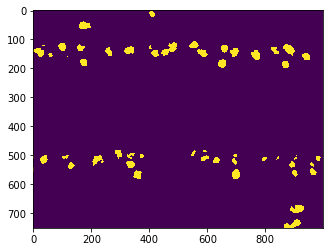

In [37]:
plt.imshow(cat.cpu().data.numpy())

In [38]:
ptsdf = pd.DataFrame.from_dict(regions)
ptsdf.file_attributes = ptsdf.file_attributes.str.replace("'", '"')
ptsdf.region_shape_attributes = ptsdf.region_shape_attributes.str.replace("'", '"')
ptsdf.region_attributes = ptsdf.region_attributes.str.replace("'", '"')
ptsdf.to_csv('../data/GP_pred_VIA.csv', index = False)

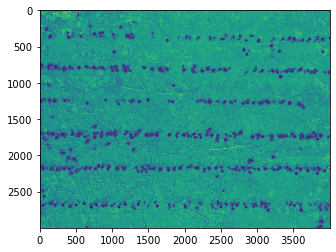

In [39]:
plt.imshow(prednormr)

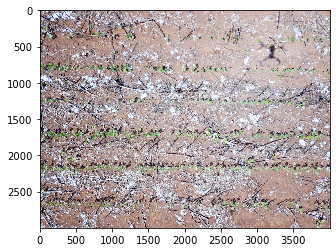

In [40]:
plt.imshow(imgo[:,:,[2,1,0]])